In [1]:
import os
import sys
import numpy as np
import sklearn as skl
import tqdm
import pandas as pd
import time
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

from models import *
from utils import *
from kalman import *

%load_ext autoreload
%autoreload 2

In [3]:
lstm = LSTMS2S(1, 40, [20,20], 1, num_layers=1, sequence_length=12,prob=True)
lstm.load_state_dict(torch.load("load_lstm.pt"))
lstm.eval()

LSTMS2S(
  (lstm): LSTM(1, 40, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [12]:
costs = [1.1,1.2,1.3,1.4,1.5,1.6]

torch.manual_seed(0)
state = lstm.initialize_lstm(torch.tensor([[[costs[0]]]]).float())
for cost in costs:
    print(cost)
    x = torch.tensor([[[cost]]])
    print(state)
    state = lstm.lstm(x.float(),state)


1.1
(tensor([[[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920, -0.3160,
          -2.1152,  0.3223, -1.2633,  0.3500,  0.3081,  0.1198,  1.2377,
           1.1168, -0.2473, -1.3527, -1.6959,  0.5667,  0.7935,  0.5988,
          -1.5551, -0.3414,  1.8530, -0.2159, -0.7425,  0.5627,  0.2596,
          -0.1740, -0.6787,  0.9383,  0.4889,  1.2032,  0.0845, -1.2001,
          -0.0048, -0.5181, -0.3067, -1.5810,  1.7066]]]), tensor([[[ 0.2055, -0.4503, -0.5731, -0.5554,  0.5943,  1.5419,  0.5073,
          -0.5910, -1.3253,  0.1886, -0.0691, -0.4949, -1.4959, -0.1938,
           0.4455,  1.3253,  1.5091,  2.0820,  1.7067,  2.3804, -1.1256,
          -0.3170, -1.0925, -0.0852,  1.6459, -1.3602,  0.3446,  0.5199,
          -2.6133, -1.6965, -0.2282,  0.2800,  0.2469,  0.0769,  0.3380,
           0.4544,  0.4569, -0.8654,  0.7813, -0.9268]]]))
1.2
(tensor([[[ 4.9239e-02, -6.4942e-01, -7.2941e-01, -4.9086e-02,  1.3838e-01,
           1.0601e-01,  3.6570e-01, -2.1360e-01, -3.4228e-04,  1.74

AttributeError: 'tuple' object has no attribute 'size'

## Load in Raw X and Y Data

In [2]:
file_location = '../data/processed'
locnum = 11
postfix = '_openei_%03d_subset_multitask.pt' %(locnum)
X0 = torch.load(os.path.join(file_location, "X"+postfix))
Y0 = torch.load(os.path.join(file_location, "Y"+postfix))

m,n = X0.shape
m,o = Y0.shape
X = torch.reshape(X0,(locnum,-1,n)).double()
Y = torch.reshape(Y0,(locnum,-1,o)).double()

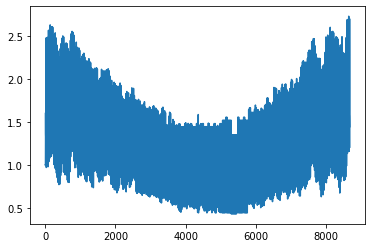

In [3]:
plt.plot(range(Y.shape[1]),Y[0,range(Y.shape[1]),0])
plt.show()

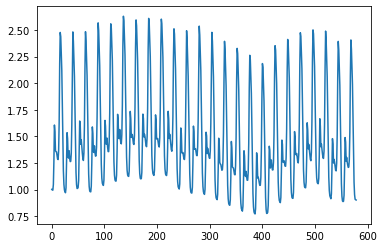

In [4]:
plt.plot(range(Y.shape[1]//15),Y[0,range(Y.shape[1]//15),0])
plt.show()

/home/arec/miniconda3/envs/blf/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


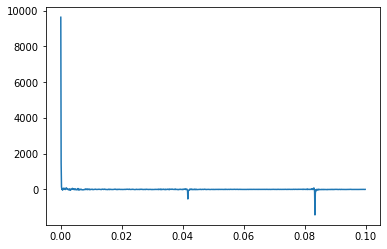

In [6]:
fourier = np.fft.fft(Y[0,:,0])
freq = np.fft.fftfreq(Y.shape[-2])
n = len(fourier)//10
plt.plot(freq[:n],fourier[:n])
plt.show()
# rough periodicity every 12 and 24 hours

In [ ]:
#np.savetxt('loads.csv', X[0,:,[0]].float().t().data.numpy(), fmt='%.8e', delimiter=',')

## Load Prediction just from time

In [7]:
xcols = [-6,-5,-4,-3,-2,-1]
ycols = [0]
X_red = X[0,:,xcols]
Y_red = X[0,:,ycols]
hidden_layers = [40,40,30]

batch_size = 32
input_size =  len(xcols)
output_size = len(ycols)

np.random.seed(0)
torch.manual_seed(0)
X_seq, Y_seq = X_red.float(), Y_red.float()
X_train, Y_train, X_test, Y_test = train_test_split(X_seq, Y_seq,proportion_test=0.1)
X_batches, Y_batches = batch(X_train, Y_train, batch_size)
fc = ARNN(input_size, hidden_layers, output_size)
train(fc, X_batches, Y_batches, num_epochs=80, learning_rate=0.01)
test(fc, X_test, Y_test,last_only=False,nn=True)
#test_naive(X_test, Y_test)

epoch : 1, loss: 0.0524
epoch : 2, loss: 0.0125
epoch : 3, loss: 0.0115
epoch : 4, loss: 0.0108
epoch : 5, loss: 0.0106
epoch : 6, loss: 0.0103
epoch : 7, loss: 0.0100
epoch : 8, loss: 0.0099
epoch : 9, loss: 0.0098
epoch : 10, loss: 0.0097
epoch : 11, loss: 0.0096
epoch : 12, loss: 0.0097
epoch : 13, loss: 0.0096
epoch : 14, loss: 0.0095
epoch : 15, loss: 0.0095
epoch : 16, loss: 0.0093
epoch : 17, loss: 0.0091
epoch : 18, loss: 0.0091
epoch : 19, loss: 0.0089
epoch : 20, loss: 0.0088
epoch : 21, loss: 0.0088
epoch : 22, loss: 0.0087
epoch : 23, loss: 0.0086
epoch : 24, loss: 0.0086
epoch : 25, loss: 0.0088
epoch : 26, loss: 0.0085
epoch : 27, loss: 0.0085
epoch : 28, loss: 0.0083
epoch : 29, loss: 0.0084
epoch : 30, loss: 0.0085
epoch : 31, loss: 0.0084
epoch : 32, loss: 0.0084
epoch : 33, loss: 0.0086
epoch : 34, loss: 0.0084
epoch : 35, loss: 0.0083
epoch : 36, loss: 0.0084
epoch : 37, loss: 0.0082
epoch : 38, loss: 0.0083
epoch : 39, loss: 0.0084
epoch : 40, loss: 0.0082
epoch : 4

In [8]:
## Save and load model
fcpath = "./load_from_time_fc.pt"
torch.save(fc.state_dict(), fcpath)

model = ARNN(input_size, hidden_layers, output_size)
model.load_state_dict(torch.load(fcpath))
model.eval()

ARNN(
  (fc): Sequential(
    (0): Linear(in_features=6, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=30, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [9]:
pred = model.forward(X_seq).detach()
residual = Y_seq - pred

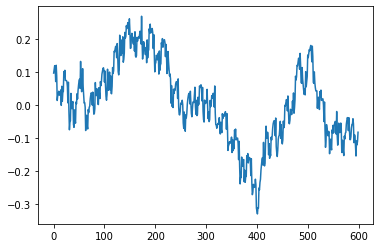

In [8]:
plt.plot(residual[:600])

In [11]:
# Safe predictions and residuals
np.savetxt('predictions.csv', pred.t().data.numpy(), fmt='%.8e', delimiter=',')
np.savetxt('residuals.csv', residual.t().data.numpy(), fmt='%.8e', delimiter=',')

## Predicting Residual Distribution w/ SSID

In [53]:
A = torch.tensor([[0.9529,0.1977,-0.1618],
                 [0.0333, 0.7930, 0.2602],
                 [-0.0098, 0.0342, -0.9402]])
C = torch.tensor([[7.7727, -0.5361, -0.0673]])
Q = 0.00001*torch.eye(3)
startidx = 1000
input_idxs = np.arange(startidx,startidx+7)
output_idxs = [startidx+7]

data = residual[input_idxs,:]
next_step = residual[output_idxs,:]
obse, obssigma, mu_history, sigma_history, obse_history, obssigma_history = kalman_fit_predict(data,A,C,Q)

In [54]:
obse

tensor([[-0.0200]])

In [55]:
obssigma_history

[tensor([[57.6136]]),
 tensor([[4.1508]]),
 tensor([[2.2737]]),
 tensor([[0.0011]]),
 tensor([[0.0011]]),
 tensor([[0.0009]]),
 tensor([[0.0009]])]

In [56]:
obse_history

[tensor([[0.]]),
 tensor([[-0.0064]]),
 tensor([[0.0258]]),
 tensor([[0.0351]]),
 tensor([[-0.0568]]),
 tensor([[-0.0066]]),
 tensor([[-0.0380]])]

In [58]:
data, next_step

(tensor([[-0.0068],
         [ 0.0340],
         [-0.0006],
         [-0.0376],
         [-0.0082],
         [-0.0427],
         [-0.0105]]),
 tensor([[-0.0120]]))

## Many-To-Many LSTM

In [8]:
#xcols = [0]
# xcols = [0,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]
# xcols = range(X.shape[2])

# ycols = [0]
# ycols = list(range(5))
# ycols = [0,1,2,3,4,10]
#ycols = [0]
# ycols = [5:10]
# ycols = [5,6,7,8,9,11]

In [5]:
xcols = [0]
ycols = [0]

X_red = X[0,:,xcols]
Y_red = Y[0,:,ycols]

hidden_size = 40
fc_hidden_layers = [20,20]
sequence_length = 12
num_layers = 1

batch_size = 32
input_size =  len(xcols)
output_size = len(ycols)

X_seq, Y_seq = create_rnn_XY(X_red,Y_red, tw=sequence_length)
X_train, Y_train, X_test, Y_test = train_test_split_rnn(X_seq, Y_seq,proportion_test=0.03)
X_batches, Y_batches = batch(X_train, Y_train, batch_size)
lstm = LSTMS2S(input_size, hidden_size, fc_hidden_layers, output_size, 
               num_layers=num_layers, sequence_length=sequence_length,prob=True)
train(lstm, X_batches, Y_batches, num_epochs=40, learning_rate=0.01,
      loss_on_last_half=True,prob=True)
#test(lstm, X_test, Y_test)
#test_naive(X_test, Y_test)

epoch : 1, loss: 17.5399
epoch : 2, loss: -144.0685
epoch : 3, loss: -194.2314
epoch : 4, loss: -263.9441
epoch : 5, loss: -285.3809
epoch : 6, loss: -303.1426
epoch : 7, loss: -321.0946
epoch : 8, loss: -347.2133
epoch : 9, loss: -358.7214
epoch : 10, loss: -371.2432
epoch : 11, loss: -378.0081
epoch : 12, loss: -387.7561
epoch : 13, loss: -402.7136
epoch : 14, loss: -408.1206
epoch : 15, loss: -401.7858
epoch : 16, loss: -413.5504
epoch : 17, loss: -422.6430
epoch : 18, loss: -424.0846
epoch : 19, loss: -425.2517
epoch : 20, loss: -438.9647
epoch : 21, loss: -436.2963
epoch : 22, loss: -441.3822
epoch : 23, loss: -453.6965
epoch : 24, loss: -440.7375
epoch : 25, loss: -448.7725
epoch : 26, loss: -458.6249
epoch : 27, loss: -465.7312
epoch : 28, loss: -467.9407
epoch : 29, loss: -466.5379
epoch : 30, loss: -474.4001
epoch : 31, loss: -479.4497
epoch : 32, loss: -471.0682
epoch : 33, loss: -471.8185
epoch : 34, loss: -482.7861
epoch : 35, loss: -477.4598
epoch : 36, loss: -484.6154
epo

In [6]:
outputs = lstm.forward(X_test)
mu,sig = outputs[:,-1,[0]],outputs[:,-1,[1]]

In [10]:
lstmpath = "./load_lstm.pt"
torch.save(lstm.state_dict(), lstmpath)

(tensor(0.0153, grad_fn=<MeanBackward0>), tensor(0.0170, grad_fn=<StdBackward0>))


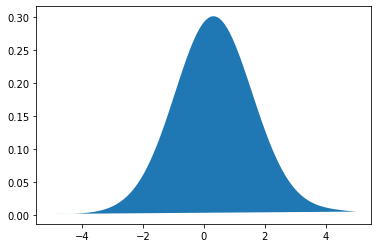

In [8]:
x = ((Y_test[:,-1]-mu)/sig).data.numpy()
xplot = np.linspace(-5,5,1000)
dens = kde(x,xplot)
print(MAPELoss(mu,Y_test[:,-1]))
plt.fill(xplot,dens)

## Autoregressive NN

In [11]:
xcols = [0]
ycols = [0]

X_red = X[0,:,xcols]
Y_red = Y[0,:,ycols]

hidden_layers = [40,40,40]
sequence_length = 6

batch_size = 32
input_size =  sequence_length
output_size = len(ycols)

X_seq, Y_seq = create_nn_XY(X_red,Y_red, tw=sequence_length)
X_train, Y_train, X_test, Y_test = train_test_split_nn(X_seq, Y_seq,proportion_test=0.03)
X_batches, Y_batches = batch(X_train, Y_train, batch_size)
fc = ARNN(input_size, hidden_layers, output_size,prob=True)
train(fc, X_batches, Y_batches, num_epochs=80, learning_rate=0.01,prob=True)
#test(fc, X_test, Y_test,last_only=False,nn=True)
#test_naive(X_test, Y_test)

epoch : 1, loss: -8.3533
epoch : 2, loss: -24.5683
epoch : 3, loss: -12.4766
epoch : 4, loss: -23.3181
epoch : 5, loss: -32.4392
epoch : 6, loss: -38.3832
epoch : 7, loss: -39.2346
epoch : 8, loss: -40.3161
epoch : 9, loss: -38.0163
epoch : 10, loss: -42.5480
epoch : 11, loss: -43.1609
epoch : 12, loss: -42.8292
epoch : 13, loss: -43.8895
epoch : 14, loss: -40.5792
epoch : 15, loss: -35.3171
epoch : 16, loss: -42.9268
epoch : 17, loss: -43.9467
epoch : 18, loss: -44.4930
epoch : 19, loss: -45.8859
epoch : 20, loss: -47.5960
epoch : 21, loss: -47.0757
epoch : 22, loss: -48.6829
epoch : 23, loss: -47.4552
epoch : 24, loss: -50.3871
epoch : 25, loss: -47.1692
epoch : 26, loss: -48.6993
epoch : 27, loss: -50.8230
epoch : 28, loss: -50.6975
epoch : 29, loss: -50.3143
epoch : 30, loss: -52.2429
epoch : 31, loss: -51.7879
epoch : 32, loss: -50.4294
epoch : 33, loss: -50.5001
epoch : 34, loss: -49.5446
epoch : 35, loss: -51.1938
epoch : 36, loss: -53.2018
epoch : 37, loss: -52.1104
epoch : 38,

(tensor(0.0377, grad_fn=<MeanBackward0>), tensor(0.0257, grad_fn=<StdBackward0>))


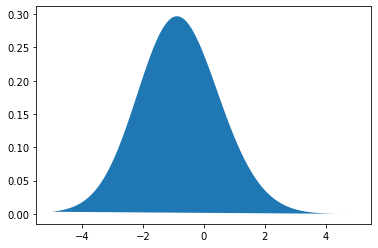

In [16]:
outputs = fc.forward(X_test)
mu,sig = outputs[:,[0]],outputs[:,[1]]

x = ((Y_test-mu)/sig).data.numpy()
xplot = np.linspace(-5,5,1000)
dens = kde(x,xplot)
print(MAPELoss(mu,Y_test))
plt.fill(xplot,dens)

In [18]:
annpath = "./load_ann.pt"
torch.save(fc.state_dict(), annpath)

In [7]:
fc = ARNN(6, [40,40,40], 1, prob=True)
fc.load_state_dict(torch.load("load_ann.pt"))
fc.eval()

ARNN(
  (fc): Sequential(
    (0): Linear(in_features=6, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=40, out_features=2, bias=True)
  )
)

In [8]:
fc.forward(torch.tensor([1.1,1.2,1.3,1.4,1.5,1.6]))

tensor([1.5585, 0.0600], grad_fn=<TransposeBackward0>)

In [48]:
xcols = [0,1,2,3,4,5,-6,-5,-4,-3,-2,-1]
ycols = [0,3]
weights = [1,6]

X_red = X[0,:,xcols]
Y_red = Y[0,:,ycols]
hidden_layers = [40,40,40]

batch_size = 32
input_size =  len(xcols)
output_size = len(ycols)

X_seq, Y_seq = X_red.float(), Y_red.float()
X_train, Y_train, X_test, Y_test = train_test_split(X_seq, Y_seq,proportion_test=0.9)
X_batches, Y_batches = batch(X_train, Y_train, batch_size)
fc = ARNN(input_size, hidden_layers, output_size)
train(fc, X_batches, Y_batches, num_epochs=80, learning_rate=0.01, weighting = weights)
test(fc, X_test, Y_test,last_only=False,nn=True)

epoch : 1, loss: 0.331
epoch : 2, loss: 0.059
epoch : 3, loss: 0.030
epoch : 4, loss: 0.018
epoch : 5, loss: 0.014
epoch : 6, loss: 0.012
epoch : 7, loss: 0.011
epoch : 8, loss: 0.010
epoch : 9, loss: 0.010
epoch : 10, loss: 0.009
epoch : 11, loss: 0.009
epoch : 12, loss: 0.009
epoch : 13, loss: 0.008
epoch : 14, loss: 0.008
epoch : 15, loss: 0.008
epoch : 16, loss: 0.008
epoch : 17, loss: 0.009
epoch : 18, loss: 0.009
epoch : 19, loss: 0.009
epoch : 20, loss: 0.010
epoch : 21, loss: 0.011
epoch : 22, loss: 0.010
epoch : 23, loss: 0.008
epoch : 24, loss: 0.007
epoch : 25, loss: 0.006
epoch : 26, loss: 0.006
epoch : 27, loss: 0.005
epoch : 28, loss: 0.005
epoch : 29, loss: 0.005
epoch : 30, loss: 0.005
epoch : 31, loss: 0.005
epoch : 32, loss: 0.005
epoch : 33, loss: 0.005
epoch : 34, loss: 0.004
epoch : 35, loss: 0.004
epoch : 36, loss: 0.004
epoch : 37, loss: 0.004
epoch : 38, loss: 0.004
epoch : 39, loss: 0.004
epoch : 40, loss: 0.004
epoch : 41, loss: 0.004
epoch : 42, loss: 0.004
e

In [49]:
weights = [4,6]
fc = ARNN(input_size, hidden_layers, output_size)
train(fc, X_batches, Y_batches, num_epochs=80, learning_rate=0.01, weighting = weights)
test(fc, X_test, Y_test,last_only=False,nn=True)

epoch : 1, loss: 0.293
epoch : 2, loss: 0.045
epoch : 3, loss: 0.019
epoch : 4, loss: 0.014
epoch : 5, loss: 0.012
epoch : 6, loss: 0.012
epoch : 7, loss: 0.011
epoch : 8, loss: 0.011
epoch : 9, loss: 0.011
epoch : 10, loss: 0.011
epoch : 11, loss: 0.011
epoch : 12, loss: 0.011
epoch : 13, loss: 0.011
epoch : 14, loss: 0.010
epoch : 15, loss: 0.010
epoch : 16, loss: 0.009
epoch : 17, loss: 0.009
epoch : 18, loss: 0.009
epoch : 19, loss: 0.009
epoch : 20, loss: 0.009
epoch : 21, loss: 0.008
epoch : 22, loss: 0.008
epoch : 23, loss: 0.008
epoch : 24, loss: 0.007
epoch : 25, loss: 0.007
epoch : 26, loss: 0.007
epoch : 27, loss: 0.007
epoch : 28, loss: 0.006
epoch : 29, loss: 0.006
epoch : 30, loss: 0.006
epoch : 31, loss: 0.006
epoch : 32, loss: 0.006
epoch : 33, loss: 0.005
epoch : 34, loss: 0.005
epoch : 35, loss: 0.005
epoch : 36, loss: 0.005
epoch : 37, loss: 0.005
epoch : 38, loss: 0.005
epoch : 39, loss: 0.005
epoch : 40, loss: 0.005
epoch : 41, loss: 0.005
epoch : 42, loss: 0.005
e

In [42]:
torch.abs(fc.forward(X_test)-Y_test) / Y_test

tensor([[0.0834, 0.2762, 0.1036],
        [0.0518, 0.0260, 0.1306],
        [0.0027, 0.0784, 0.2058],
        ...,
        [0.0084, 0.0871, 0.0910],
        [0.1038, 0.0462, 0.0569],
        [0.1127, 0.0169, 0.0731]], grad_fn=<DivBackward0>)

In [30]:
X_train.shape

torch.Size([174, 12])

# Scratch Misc

In [5]:
def create_inout_sequences(xs, ys, tw):
    inout_seq = []
    L = len(xs)
    for i in range(L-tw):
        train_seq = xs[i:i+tw,0].float()
        train_label = ys[i+tw-1,:].float()
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [6]:
cols = [0] #,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]
X_red = X[0,:,cols]
Y_red = Y[0,:,[0]]

inout_seq = create_inout_sequences(X_red,Y_red,24)